In [1]:
from ML_point_tf import *
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
sess = tf.InteractiveSession()

In [30]:
# maml = MAML_HB()
# merged_summary = tf.summary.merge_all()

# tf.global_variables_initializer().run()

# train_writer = tf.summary.FileWriter("logs", sess.graph)

# for i in range(2500):
#     tasks = draw_sin_tasks(25)
#     summary, _, loss, theta = sess.run([merged_summary, maml.train_op, maml.loss, maml.theta], feed_dict={tp: task for tp, task in zip(maml.tasks, tasks)})
        
#     train_writer.add_summary(summary, i)
#     if i % 100 == 0:
#         print("Iter {}:".format(i), loss)

In [231]:
def sample_sin_test_pts(K, amplitude, phase, mini = -5, maxi = 5):
    input_points = np.random.uniform(mini, maxi, K)
    output_points = amplitude * np.sin(input_points + phase)
    print(np.expand_dims(input_points.T, axis=1).astype("float32").shape)
    return np.expand_dims(input_points.T, axis=1).astype("float32"), np.expand_dims(output_points.T, axis=1).astype("float32")

In [232]:
def sample_sin_test_pts_input(input_points):
    #sample sin test pts only given input
    output_points = amplitude * np.sin(input_points + phase)
    print(np.expand_dims(input_points.T, axis=1).astype("float32").shape)
    return np.expand_dims(input_points.T, axis=1).astype("float32"), np.expand_dims(output_points.T, axis=1).astype("float32")

In [32]:
sample_sin_test_pts(5, .5, np.pi/2)

(5, 1)


(array([[-1.1620479 ],
        [-0.9348006 ],
        [-1.0661478 ],
        [-0.46005917],
        [ 4.383152  ]], dtype=float32), array([[ 0.1987306 ],
        [ 0.2969894 ],
        [ 0.24174991],
        [ 0.44801313],
        [-0.16166064]], dtype=float32))

In [33]:
def plot_points_with_sin(train_pts, test_pts, amplitude, phase, i, save=False):
    t = np.arange(-5, 5, 0.1)
    fig = plt.figure()
    plt.plot(t, amplitude*np.sin(t + phase))
    plt.grid(True)
    plt.plot(train_pts[0], train_pts[1], "go")
    plt.plot(test_pts[0], test_pts[1], "ro")
    plt.title("Iter={}".format(i))
    if save:
        fig.savefig("{}.png".format(i), bbox_inches='tight')
    plt.show()
    plt.close()

In [330]:
def plot_points_with_sin_uncertain(train_pts, test_pt_inp, test_pt_preds, amplitude, phase, i, save=False):
    t = np.arange(-5, 5, 0.1)
    fig = plt.figure()
    plt.plot(t, amplitude*np.sin(t + phase))
    plt.grid(True)
    plt.plot(train_pts[0], train_pts[1], "go")
    for j, pred in enumerate(test_pt_preds):
        c = "b"
        z_ord = 1
        if j == 0: #the first color is red, since it's the mean of the posterior
            c = "r"
            z_ord = 5
        plt.plot(test_pt_inp, pred, c)
        plt.plot(test_pt_inp, pred, c + "o", zorder = z_ord)

            
    plt.title("Iter={}".format(i))
    
    if save:
        fig.savefig("{}-uncertainty.png".format(i), bbox_inches='tight')
    plt.show()
    plt.close()

In [35]:
lit_theta = np.load('theta-67500.npy').item()

In [36]:
maml3 = MAML_HB(lit_theta)

Restoring theta from ckpt
{'w1': <tf.Variable 'w1_1:0' shape=(1, 40) dtype=float32_ref>, 'b1': <tf.Variable 'b1_1:0' shape=(40,) dtype=float32_ref>, 'w2': <tf.Variable 'w2_1:0' shape=(40, 40) dtype=float32_ref>, 'b2': <tf.Variable 'b2_1:0' shape=(40,) dtype=float32_ref>, 'out': <tf.Variable 'out_1:0' shape=(40, 1) dtype=float32_ref>, 'outb': <tf.Variable 'outb_1:0' shape=(1,) dtype=float32_ref>}


In [40]:
tf.global_variables_initializer().run()

In [230]:
def eval_theta(maml, i, save_fig):
    task = [.5, np.pi/2]
    K = 15
    inps, outs = sample_sin_test_pts(K, task[0], task[1])

    test_ins = np.expand_dims(np.arange(-5, 5, 1).T, axis=1).astype("float32")
    inp_placeholder = tf.placeholder(tf.float32, (K,1))
    test_outs, flat_phi, hessian = maml.finetune_and_test_hessian(inp_placeholder, outs, 15, test_ins, 40)
    test_outs_, flat_phi_, hessian_ = sess.run([test_outs, flat_phi, hessian], feed_dict={inp_placeholder: inps})
    #test_outs_ = test_outs_[0]
    hessian_ = hessian_[0]
    flat_phi_ = flat_phi_[0]
    np.linalg.cholesky(hessian_) #this is to check it's PSD
    plot_points_with_sin((inps, outs), (test_ins, test_outs_), task[0], task[1], i, save_fig)

(15, 1)


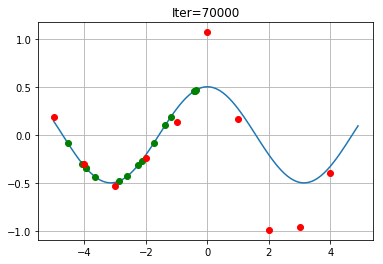

In [243]:
eval_theta(maml3, 70000, True)

In [316]:
def eval_theta_hessian(maml):
    "Given a maml will generate a test of test inputs and then adapt"
    "Returns the test inputs, flattened adapted parameters and hessian at the adapted parameters"
    task = [.5, np.pi/2]
    K = 15
    inps, outs = sample_sin_test_pts(K, task[0], task[1], mini = -5, maxi = 0)

    test_ins = np.expand_dims(np.arange(-5, 5, 1).T, axis=1).astype("float32")
    #test_ins = np.expand_dims(np.array([-4., -2., 2., 3., 4.]), axis = 1).astype("float32")
    test_ins = np.sort(test_ins)
    inp_placeholder = tf.placeholder(tf.float32, (K,1))
    inp_tau = 0.
    test_outs, flat_phi, hessian = maml.finetune_and_test_hessian(inp_placeholder, outs, 15, test_ins, inp_tau)
    test_outs_, flat_phi_, hessian_ = sess.run([test_outs, flat_phi, hessian], feed_dict={inp_placeholder: inps})
    #test_outs_ = test_outs_[0]
    hessian_ = hessian_[0]
    min_eig_val = np.real(np.linalg.eigvals(hessian_).min())
    print("OG min eigval", min_eig_val)
#     try:
#         np.linalg.cholesky(hessian_)
#     except:
#         print('OG not PSD')
#         hessian_ = hessian_ + np.eye(1761) * (-min_eig_val + 0.1)
#         np.linalg.cholesky(hessian_)
#         print("New min eigval", np.linalg.eigvals(hessian_).min())
    return inps, outs, test_ins, flat_phi_, hessian_

In [317]:
inps, outs, test_ins, flat_phi, hessian = eval_theta_hessian(maml3)

(15, 1)
OG min eigval -0.61784667


In [318]:
print(hessian)

[[  82.35031   -195.64134     70.75509   ...    6.283151     0.
     4.126391 ]
 [-195.64137    550.1941    -201.76039   ...  -10.298074     0.
    -6.10814  ]
 [  70.75509   -201.7604     221.0719    ...  -14.511976     0.
   -11.874964 ]
 ...
 [   6.283151   -10.298076   -14.511975  ...    3.2417967    0.
     2.52776  ]
 [   0.           0.           0.        ...    0.           0.
     0.       ]
 [   4.1263905   -6.108139   -11.874962  ...    2.5277598    0.
     2.       ]]


In [319]:
print(np.diag(hessian))
print(np.diag(hessian).mean())
print(np.diag(hessian).std())
print(np.diag(hessian).min())
print(np.diag(hessian).max())

[ 82.35031   550.1941    221.0719    ...   3.2417967   0.
   2.       ]
1.8869745
19.272726
0.0
550.1941


In [331]:
def eval_theta_uncertain_sample_only(maml, i, save_fig, inps, outs, test_ins, flat_phi, hessian):
    S = 2
    
    task = [.5, np.pi/2]
    
    damping_fac = 5000
    hessian_damp = np.eye(1761) * damping_fac
    inv = np.linalg.inv(hessian_damp)
    print("Diagonal of covariance", np.diag(inv))
    print("Min eigval of covariance", np.linalg.eigvals(inv).min())
    
    new_phis = np.random.multivariate_normal(flat_phi, inv, size = S)
    
    #alternative sampling
#     A = np.linalg.cholesky(np.linalg.inv(hessian))
#     z = np.random.multivariate_normal(np.zeros(1761), np.eye(1761))
#     sample = np.matmul(A,z) + flat_phi
#     sample = np.real(sample)
#     new_phis = [sample]

    flat_phi_placeholder = tf.placeholder(tf.float32, (1761,1))
    test_out = maml.test_pred(test_ins, flat_phi_placeholder)
    
    og_pred = sess.run([test_out], feed_dict={flat_phi_placeholder: np.expand_dims(flat_phi, 1)})[0]
    test_preds = [og_pred]
    
    for aphi in new_phis:
        #print("Avg norm", np.linalg.norm(aphi - flat_phi)/1761.)
        outpred = sess.run([test_out], feed_dict={flat_phi_placeholder: np.expand_dims(aphi, 1)})[0]
        test_preds.append(outpred)
    
    #print("plotting")
    test_preds_prime = np.squeeze(np.array(test_preds)).T
    for row, inp in zip(test_preds_prime, test_ins):
        print(inp, row[0], row.mean(), row.std())
        
#     print(test_preds_prime.shape)
#     print(test_preds_prime[0])
#     print(test_preds_prime[0].mean(), test_preds_prime[0].std())
#     print(test_preds_prime[1])
#     print(test_preds_prime[1].mean(), test_preds_prime[1].std())
    plot_points_with_sin_uncertain((inps, outs), test_ins, test_preds, task[0], task[1], i, True)
    return test_preds_prime

Diagonal of covariance [0.0002 0.0002 0.0002 ... 0.0002 0.0002 0.0002]
Min eigval of covariance 0.0002
[-5.] 0.007651031 -0.07456704 0.46381193
[-4.] -0.38956422 -0.69787234 0.5550361
[-3.] -0.39588457 -0.28599688 0.08573664
[-2.] -0.77963895 -0.8801988 0.11104528
[-1.] 0.2521345 -0.14836676 0.28401858
[0.] 1.0887315 0.63648134 0.5779154
[1.] 0.057328165 -0.20838459 0.20831244
[2.] -0.7558611 -0.97702736 0.3696767
[3.] -0.92499906 -0.93055105 0.08943537
[4.] -0.5481842 -0.64037806 0.19771571


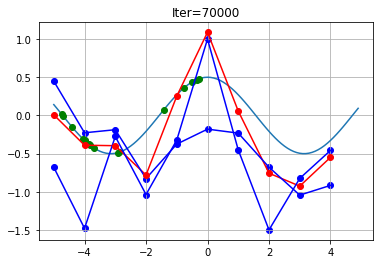

In [332]:
test_preds_prime = eval_theta_uncertain_sample_only(maml3, 70000, True, inps, outs, test_ins, flat_phi, hessian)

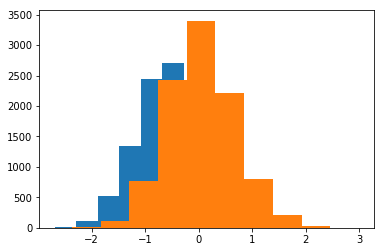

In [324]:
plt.hist(test_preds_prime[-1])
#plt.show()
plt.hist(test_preds_prime[0])
plt.show()

In [284]:
def eval_theta_uncertain(maml, i, save_fig):
    task = [.5, np.pi/2]
    K = 15
    inps, outs = sample_sin_test_pts(K, task[0], task[1])

    test_ins = np.expand_dims(np.arange(-5, 5, 1).T, axis=1).astype("float32")
    inp_placeholder = tf.placeholder(tf.float32, (K,1))
    test_outs, flat_phi, hessian = maml.finetune_and_test_hessian(inp_placeholder, outs, 15, test_ins)
    test_outs_, flat_phi_, hessian_ = sess.run([test_outs, flat_phi, hessian], feed_dict={inp_placeholder: inps})
    #test_outs_ = test_outs_[0]
    hessian_ = hessian_[0]

    test_preds = [test_outs_]
    #plot_points_with_sin((inps, outs), (test_ins, test_outs_), task[0], task[1], i, True)
    print("sampling")
    S = 20
    new_phis = np.random.multivariate_normal(flat_phi_, np.linalg.inv(hessian_) + np.eye(1761)*(1e-12), size = S)
    flat_phi_placeholder = tf.placeholder(tf.float32, (1761,1))
    test_out = maml.test_pred(test_ins, flat_phi_placeholder)

    for aphi in new_phis:
        outpred = sess.run([test_out], feed_dict={flat_phi_placeholder: np.expand_dims(aphi, 1)})[0]
        test_preds.append(outpred)
    
    print("plotting")
    plot_points_with_sin_uncertain((inps, outs), test_ins, test_preds, task[0], task[1], i, True)

In [285]:
eval_theta_uncertain(maml, 2500, True)

NameError: name 'maml' is not defined

# Real code lol

Iter 0: 1.9429638
(15, 1)
Iter 100: 4.3053107
Iter 200: 5.492766
Iter 300: 4.9121437
Iter 400: 4.39927
Iter 500: 3.4211228
Iter 600: 4.0409865
Iter 700: 3.7131906
Iter 800: 2.97464
Iter 900: 2.9105933
Iter 1000: 2.8258407
Iter 1100: 3.1037452
Iter 1200: 2.154155
Iter 1300: 2.9125705
Iter 1400: 2.9971676
Iter 1500: 3.2604694
Iter 1600: 2.2598991
Iter 1700: 2.2213156
Iter 1800: 2.711128
Iter 1900: 2.4379165
Iter 2000: 1.721957
Iter 2100: 1.6149185
Iter 2200: 3.3533971
Iter 2300: 1.547767
Iter 2400: 2.3328092
Iter 2500: 2.8374276
(15, 1)
Iter 2600: 1.9701401
Iter 2700: 1.8912371
Iter 2800: 2.432065
Iter 2900: 2.626224
Iter 3000: 1.6598504
Iter 3100: 1.3749166
Iter 3200: 2.1697295
Iter 3300: 2.9526033
Iter 3400: 1.6432027
Iter 3500: 1.4986475
Iter 3600: 1.9996245
Iter 3700: 1.5634013
Iter 3800: 2.2135317
Iter 3900: 1.9865298
Iter 4000: 1.9310702
Iter 4100: 1.6626959
Iter 4200: 2.1667686
Iter 4300: 2.4341516
Iter 4400: 2.3323433
Iter 4500: 1.8159162
Iter 4600: 2.1910686
Iter 4700: 2.0257418

Iter 37000: 0.6769162
Iter 37100: 0.3550781
Iter 37200: 0.6656288
Iter 37300: 0.51593256
Iter 37400: 0.51258445
Iter 37500: 0.5631565
(15, 1)
Iter 37600: 0.40669876
Iter 37700: 0.55472517
Iter 37800: 0.47487175
Iter 37900: 0.3900856
Iter 38000: 0.41382217
Iter 38100: 0.5163083
Iter 38200: 0.43775582
Iter 38300: 0.6208341
Iter 38400: 0.52091616
Iter 38500: 0.6715976
Iter 38600: 0.5113903
Iter 38700: 0.47449058
Iter 38800: 0.52870864
Iter 38900: 0.31292617
Iter 39000: 0.42819387
Iter 39100: 0.51314855
Iter 39200: 0.41191497
Iter 39300: 0.4959229
Iter 39400: 0.24446987
Iter 39500: 0.518432
Iter 39600: 0.5158825
Iter 39700: 0.48388967
Iter 39800: 0.59423155
Iter 39900: 0.35522538
Iter 40000: 0.4478891
(15, 1)
Iter 40100: 0.5029582
Iter 40200: 0.6592511
Iter 40300: 0.41223118
Iter 40400: 0.54258996
Iter 40500: 0.49012783
Iter 40600: 0.3638175
Iter 40700: 0.36955562
Iter 40800: 0.39929372
Iter 40900: 0.6040973
Iter 41000: 0.45058417
Iter 41100: 0.50751305
Iter 41200: 0.50937444
Iter 41300: 0

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iter 50100: 0.5228701
Iter 50200: 0.4372181
Iter 50300: 0.6018467
Iter 50400: 0.33021775
Iter 50500: 0.6495538
Iter 50600: 0.59112906
Iter 50700: 0.48288047
Iter 50800: 0.60053194
Iter 50900: 0.61950976
Iter 51000: 0.39362743
Iter 51100: 0.69550925
Iter 51200: 0.80288213
Iter 51300: 0.6608554
Iter 51400: 0.7324933
Iter 51500: 0.5493917
Iter 51600: 0.49523178
Iter 51700: 0.4846405
Iter 51800: 0.43179166
Iter 51900: 0.5485038
Iter 52000: 0.45709705
Iter 52100: 0.41680744
Iter 52200: 0.5703829
Iter 52300: 0.45039654
Iter 52400: 0.47591168
Iter 52500: 0.3684931
(15, 1)
Iter 52600: 0.59438825
Iter 52700: 0.60078305
Iter 52800: 0.61391073
Iter 52900: 0.36981034
Iter 53000: 0.34077087
Iter 53100: 0.3555313
Iter 53200: 0.52796847
Iter 53300: 0.53245306
Iter 53400: 0.5420286
Iter 53500: 0.515228
Iter 53600: 0.5270291
Iter 53700: 0.31490082
Iter 53800: 0.46613818
Iter 53900: 0.48068506
Iter 54000: 0.33692968
Iter 54100: 0.33042786
Iter 54200: 0.49468458
Iter 54300: 0.59524286
Iter 54400: 0.39446

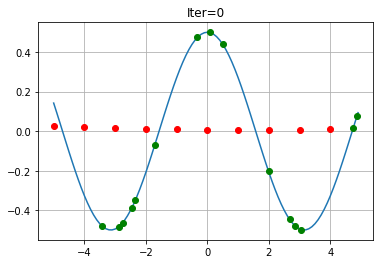

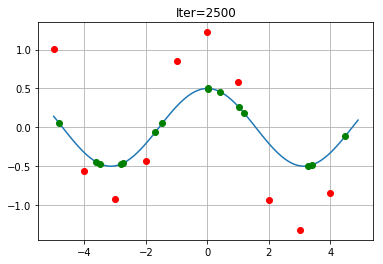

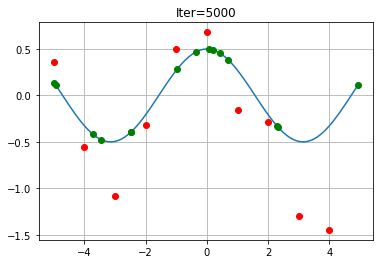

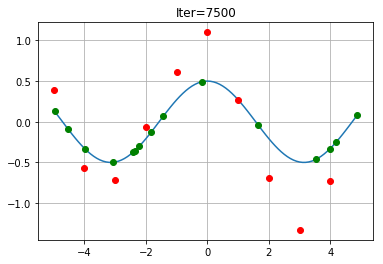

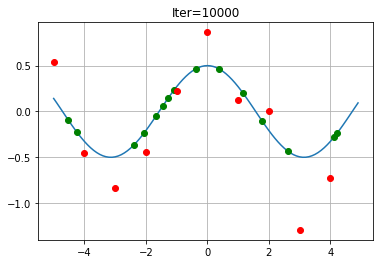

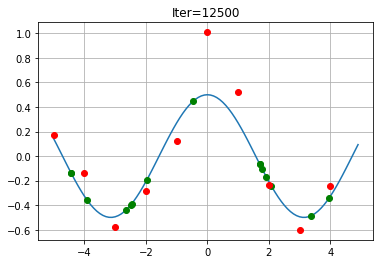

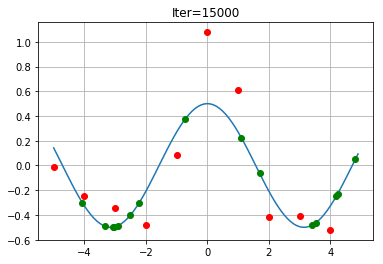

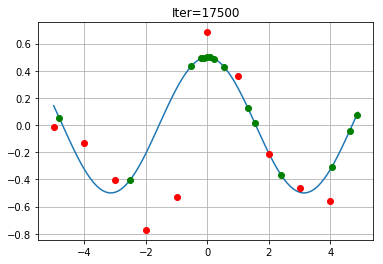

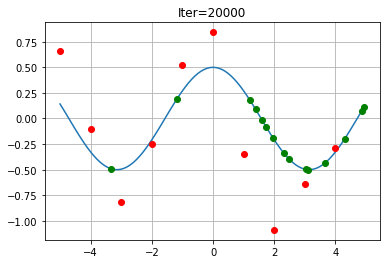

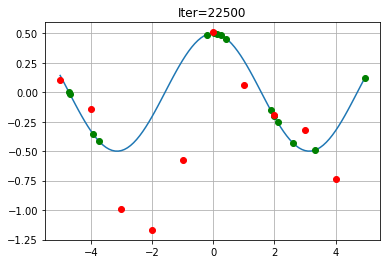

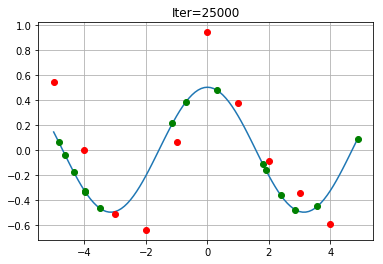

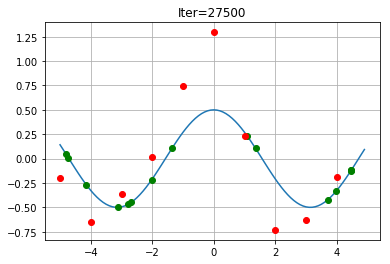

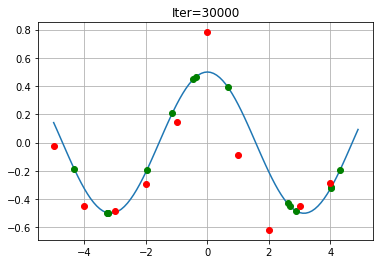

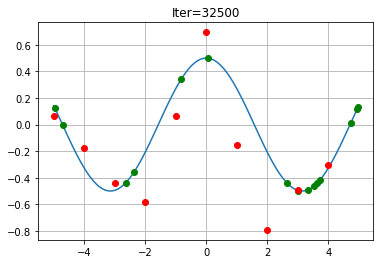

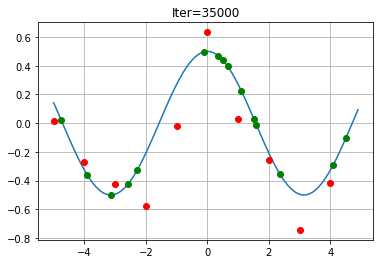

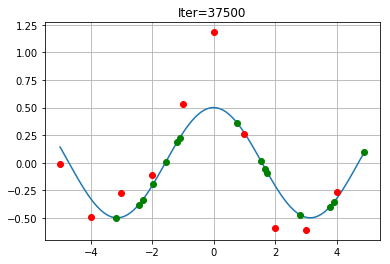

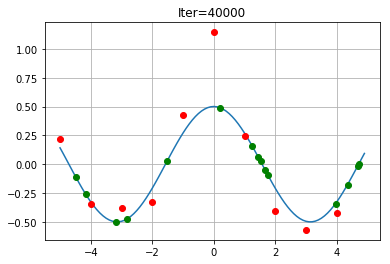

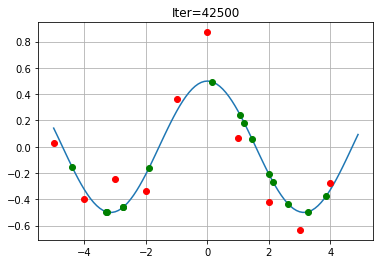

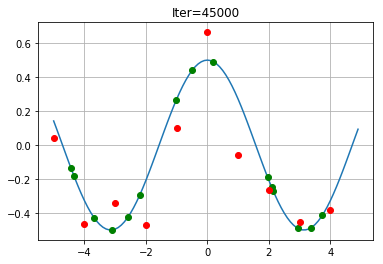

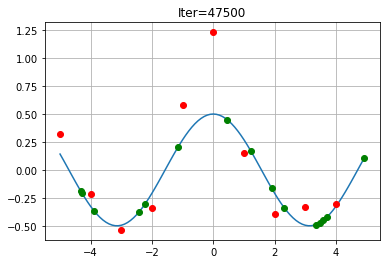

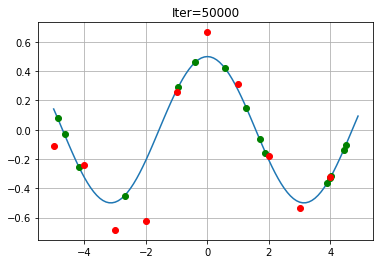

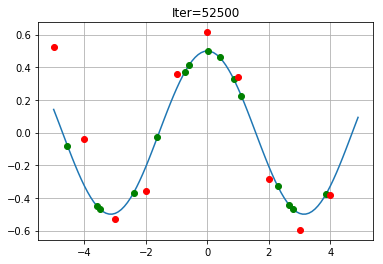

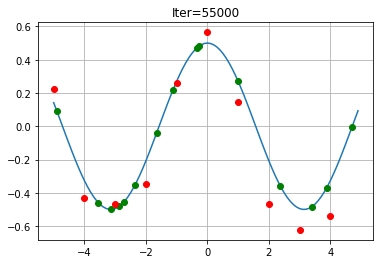

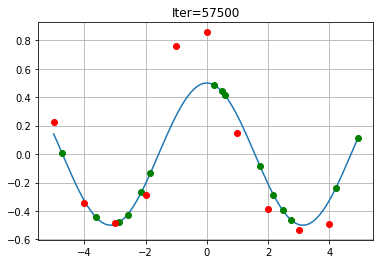

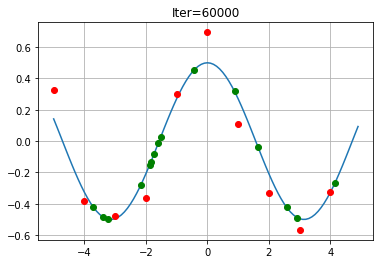

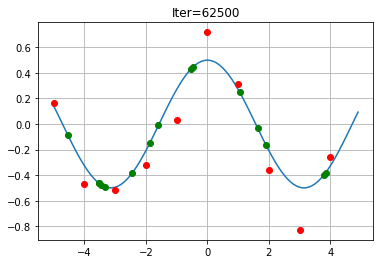

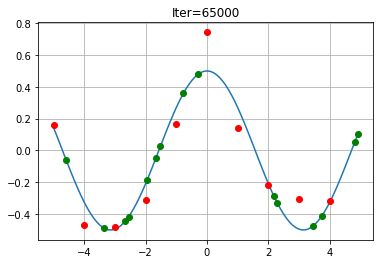

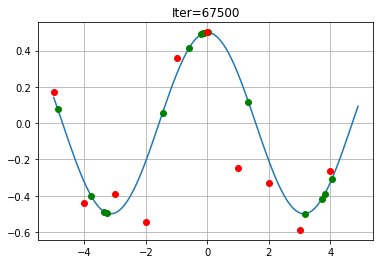

In [12]:
sess = tf.InteractiveSession()
maml2 = MAML_HB()
merged_summary = tf.summary.merge_all()

tf.global_variables_initializer().run()

train_writer = tf.summary.FileWriter("logs", sess.graph)

for i in range(70000):
    tasks = draw_sin_tasks(25)
    summary, _, loss, theta = sess.run([merged_summary, maml2.train_op, maml2.loss, maml2.theta], feed_dict={tp: task for tp, task in zip(maml2.tasks, tasks)})
        
    train_writer.add_summary(summary, i)
    if i % 100 == 0:
        print("Iter {}:".format(i), loss)
    if i % 2500 == 0:
        eval_theta(maml2, i, True)
        np.save("theta-{}.npy".format(i), theta)

# Linear model eval

In [ ]:
import linear_model

In [ ]:
sess = tf.InteractiveSession()
maml2 = MAML_HB()
merged_summary = tf.summary.merge_all()

tf.global_variables_initializer().run()

train_writer = tf.summary.FileWriter("logs", sess.graph)

for i in range(70000):
    tasks = draw_sin_tasks(25)
    summary, _, loss, theta = sess.run([merged_summary, maml2.train_op, maml2.loss, maml2.theta], feed_dict={tp: task for tp, task in zip(maml2.tasks, tasks)})
        
    train_writer.add_summary(summary, i)
    if i % 100 == 0:
        print("Iter {}:".format(i), loss)
    if i % 2500 == 0:
        eval_theta(maml2, i, True)
        np.save("theta-{}.npy".format(i), theta)